In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt

from torch.nn import Module

In [3]:
def affine(xa, xb, a, b):
    return lambda x: a + (b - a) / (xb - xa) * (x - xa)

def S(x):
    return torch.where(
        x < -1.0,
        0.0,
        torch.where(
            x < 0.0,
            0.5 * (x + 1.0)**2,
            torch.where(
                1.0 < x,
                1.0,
                1.0 - 0.5 * (x - 1)**2,
            ),
        )
    )

def dS(x):
    return torch.where(
        (x < -1.0) + (x > 1.0),
        0.0,
        torch.where(
            x < 0.0,
            x + 1,
            1 - x
        )
    )

def B(x):
    return torch.where(
        (x < -1.0) + (x > 1.0),
        0.0,
        torch.where(
            x < -0.5,
            2 * (x + 1)**2,
            torch.where(
                x < 0.5,
                1 - 2*x**2,
                2 * (x - 1)**2
            )            
        )
    )

def dB(x):
    return torch.where(
        (x < -1.0) + (x > 1.0),
        0.0,
        torch.where(
            x < -0.5,
            4 * (x + 1),
            torch.where(
                x < 0.5,
                - 4 * x,
                4 * (x - 1)
            )
        )
    )


def L(x):
    return torch.where(
        (x < -1.0) + (x > 1.0),
        0.0,
        torch.where(
            x < 0.0,
            1 - x**2,
            torch.where(
                x < 0.5,
                1 - 2 * x**2,
                2 * (x - 1)**2
            )
        )
    )


def dL(x):
    return torch.where(
        (x < -1.0) + (x > 1.0),
        0.0,
        torch.where(
            x < 0.0,
            - 2 * x,
            torch.where(
                x < 0.5,
                - 4 * x,
                - 4 * (1 - x)
            )
        )
    )

In [219]:
def bump(x0, x1):
    l = affine(x0, x1, -1, 1)
    return lambda x: ((x1 - x0) / 4) * B(l(x))

def bump_derivative(x0, x1):
    l = affine(x0, x1, -1, 1)
    return lambda x: 0.5 * dB(l(x))

def left_bump(x0, x1):
    l = affine(x0, x1, -1, 1)
    return lambda x: ((x1 - x0) / 4) * L(l(x))

def left_bump_derivative(x0, x1):
    l = affine(x0, x1, -1, 1)
    return lambda x: 0.5 * dL(l(x))

def right_bump(x0, x1):
    l = affine(x0, x1, 1, -1)
    return lambda x: ((x1 - x0) / 4) * L(l(x))

def right_bump_derivative(x0, x1):
    l = affine(x0, x1, 1, -1)
    return lambda x: - 0.5 * dL(l(x))

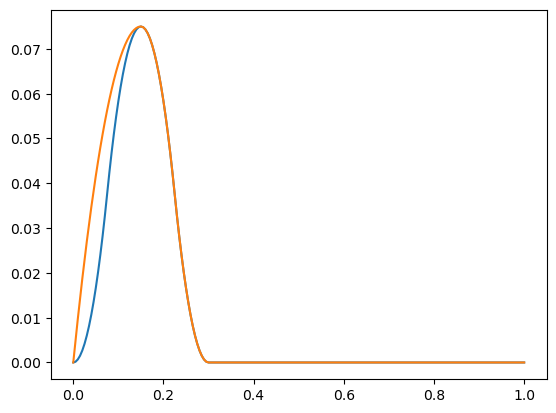

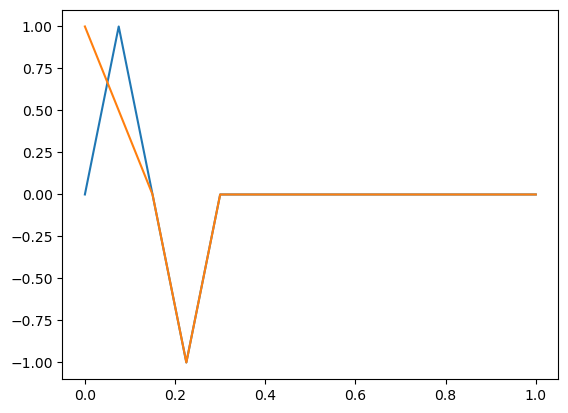

In [220]:
x = torch.linspace(0, 1, 401)
x = col_linspace(0, 1, 201)

plt.figure()
plt.plot(x, bump(0, 0.3)(x))
plt.plot(x, left_bump(0, 0.3)(x))


plt.figure()
plt.plot(x, bump_derivative(0, 0.3)(x))
plt.plot(x, left_bump_derivative(0, 0.3)(x))

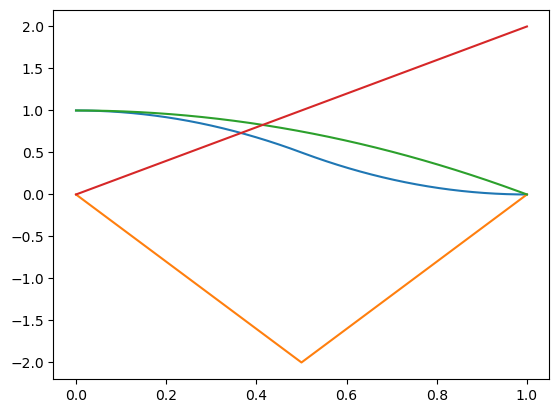

In [221]:
plt.plot(x, L(x))
plt.plot(x, dL(x))
plt.plot(x, L(-x))
plt.plot(x, dL(-x))

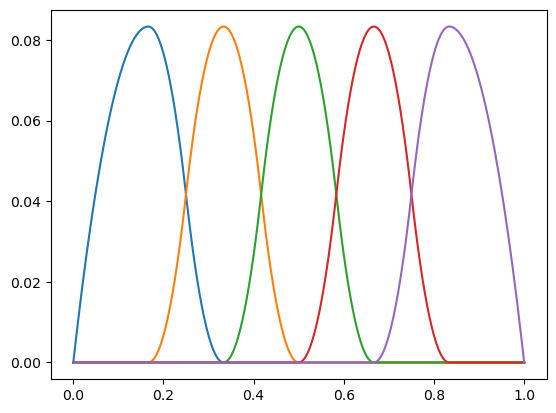

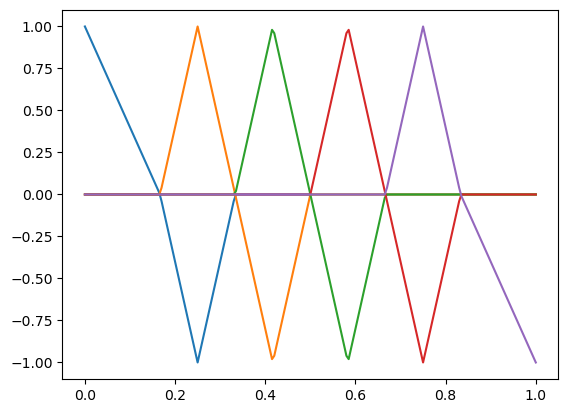

In [222]:
n = 5
nodes = torch.linspace(0, 1, n+2)

bumps = [
    left_bump(nodes[0], nodes[2]),
    *(bump(x0, x1) for x0, x1 in zip(nodes[1:-3], nodes[3:-1])),
    right_bump(nodes[-3], nodes[-1])
]

bump_derivatives = [
    left_bump_derivative(nodes[0], nodes[2]),
    *(bump_derivative(x0, x1) for x0, x1 in zip(nodes[1:-3], nodes[3:-1])),
    right_bump_derivative(nodes[-3], nodes[-1])
]

plt.figure()
for bi in bumps:
    plt.plot(x, bi(x))
plt.show()

plt.figure()
for dbi in bump_derivatives:
    plt.plot(x, dbi(x))
plt.show()

In [223]:
from funcshape.layers.layerbase import DeepShapeLayer

In [310]:
from funcshape.layers.layerbase import DeepShapeLayer

class BumpLayer(DeepShapeLayer):
    def __init__(self, nodes, init_scale=0.0):
        super().__init__()
        self.n = len(nodes) - 2
        assert self.n >= 3, "Need minimum 3 functions."
        self.bumps = [
            left_bump(nodes[0], nodes[2]),
            *(bump(x0, x1) for x0, x1 in zip(nodes[1:-3], nodes[3:-1])),
            right_bump(nodes[-3], nodes[-1])
        ]

        self.bump_derivatives = [
            left_bump_derivative(nodes[0], nodes[2]),
            *(bump_derivative(x0, x1) for x0, x1 in zip(nodes[1:-3], nodes[3:-1])),
            right_bump_derivative(nodes[-3], nodes[-1])
        ]
        
        self.weights = torch.nn.Parameter(
            init_scale * torch.randn(self.n, 1, requires_grad=True)
        )
    def forward(self, x):
        X = torch.concat(
            [
                l(x) for l in self.bumps
            ],
            dim=-1
        )
        return x + X @ self.weights
    def derivative(self, x, h=1e-4):
        X = torch.concat(
            [
                l(x) for l in self.bump_derivatives
            ],
            dim=-1
        )
        return 1.0 + X @ self.weights


    def project(self, eps=1e-6):
        bound = 1.0 - eps
        with torch.no_grad():
            if self.n == 1:
                L = self.weights[0]
            else:
                Ln = torch.abs(self.weights[:-1]) + torch.abs(self.weights[1:])
                L = float(torch.max(Ln))
            if L >= bound:
                self.weights *= bound / L

#### Verify that bumps are available

In [311]:
BLn = BumpLayer(nodes, 1.0)
BLn.weights

Parameter containing:
tensor([[-0.3496],
        [-0.0239],
        [ 1.0248],
        [-0.5410]], requires_grad=True)

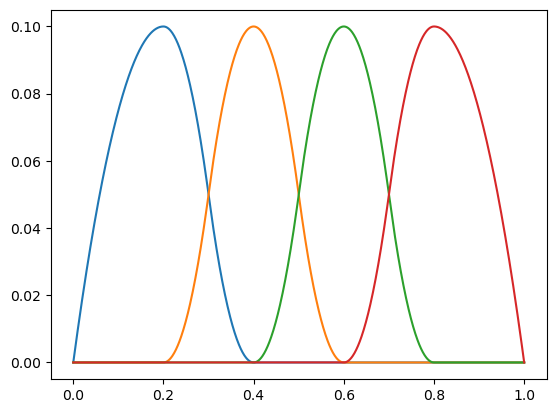

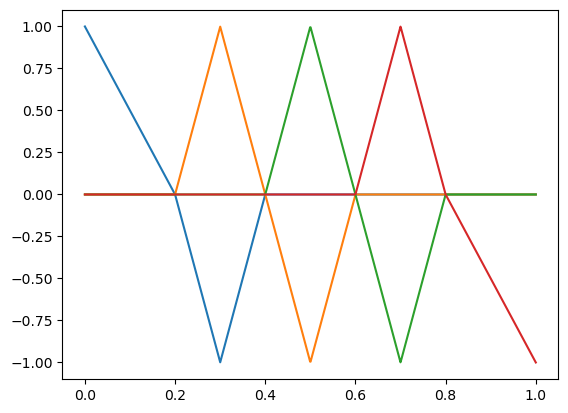

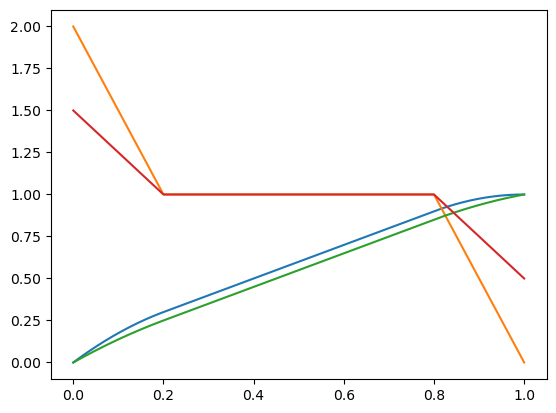

In [312]:
n = 4
nodes = torch.linspace(0, 1, n+2)
BLn = BumpLayer(nodes, 1.0)

with torch.no_grad():
    BLn.weights = torch.nn.Parameter(torch.ones(n, 1))
    plt.figure()
    for bi in BLn.bumps:
        plt.plot(x, bi(x))
        
    plt.figure()
    for dbi in BLn.bump_derivatives:
        plt.plot(x, dbi(x))
        
        
    plt.figure()
    plt.plot(x, BLn(x))
    plt.plot(x, BLn.derivative(x))
    
    BLn.project()
    plt.plot(x, BLn(x))
    plt.plot(x, BLn.derivative(x))    
plt.show()

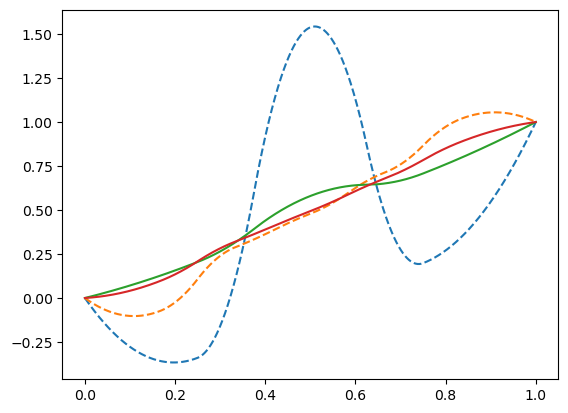

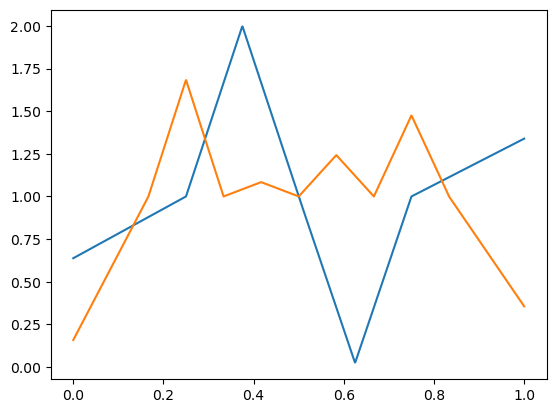

In [326]:
n, m = 3, 5
xn = torch.linspace(0.0, 1.0, n+2)
xm = torch.linspace(0.0, 1.0, m+2)

BLn = BumpLayer(xn)
BLm = BumpLayer(xm)

with torch.no_grad():
    BLn.weights += 5 * torch.randn(n, 1)
    BLm.weights += 5 * torch.randn(m, 1)
    
    plt.figure()
    plt.plot(x, BLn(x), "--")
    plt.plot(x, BLm(x), "--")

    BLn.project()
    BLm.project()
    
    plt.plot(x, BLn(x))
    plt.plot(x, BLm(x))
    
    plt.figure()
    plt.plot(x, BLn.derivative(x))
    plt.plot(x, BLm.derivative(x))
plt.show()

In [327]:
bfgs_tolerance_grad=1e-9


Finished training in 1.84477s


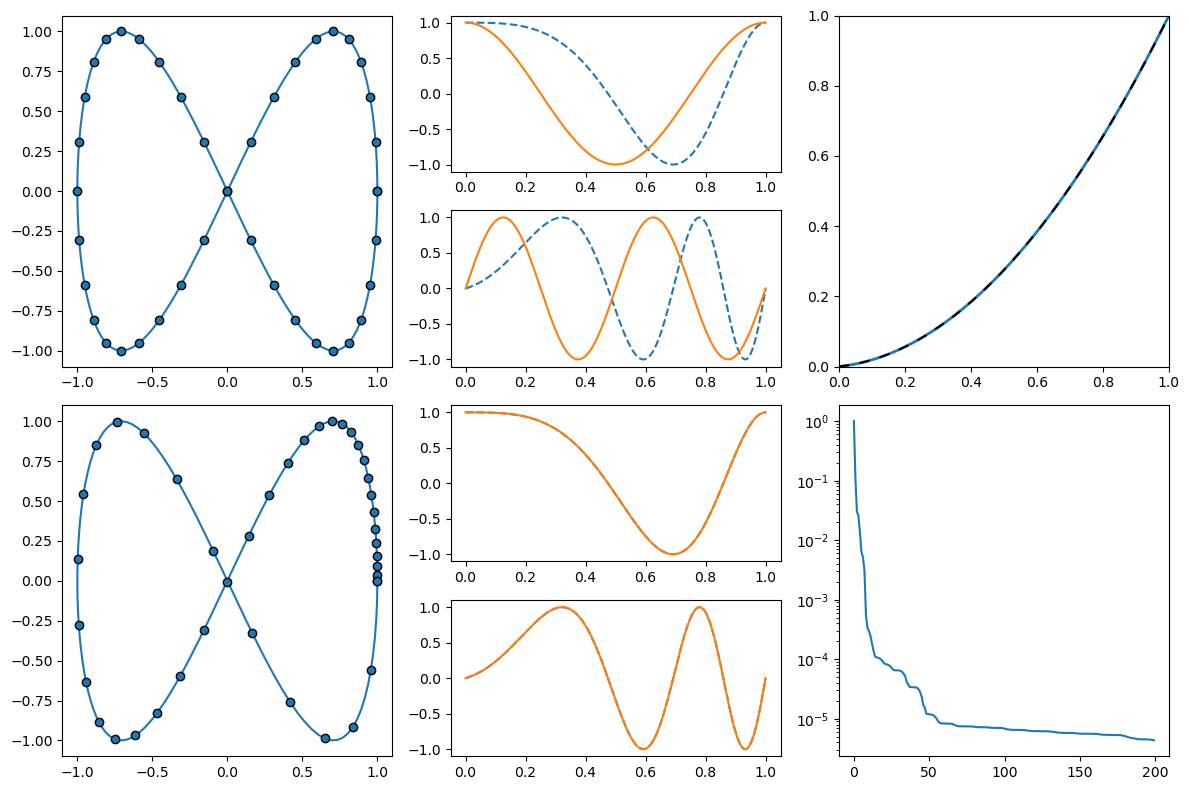

In [334]:
# Analytic diffeomorphism
g = QuadDiff()#.compose(LogStepDiff())

# Define Curves 
c1 = Infinity()
c2 = c1.compose(g)

# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
q, r = Qmap1D(c2), Qmap1D(c1)


# Create reparametrization network
RN = CurveReparametrizer([
    MultiBumpLayer([3, 5, 7]) for i in range(10)
])
RN = CurveReparametrizer([
    SineSeries(10) for i in range(10)
])
# RN = CurveReparametrizer([
#     BumpLayer(torch.linspace(0, 1, 4+2)) for i in range(10)
# ])
# nlist = (10, 7, 5, 4, 3)
# RN = CurveReparametrizer([
#     BumpLayer(torch.linspace(0, 1, ni+2)) for ni in nlist
# ])


# Define loss, optimizer and run reparametrization.
loss_func = CurveDistance(q, r, k=1024)
optimizer = optim.LBFGS(
    RN.parameters(),
    max_iter=200,
    line_search_fn='strong_wolfe',
    tolerance_grad=bfgs_tolerance_grad,
    )
error = reparametrize(RN, loss_func, optimizer, 300, Logger(0))

# Get plot data to visualize diffeomorphism
RN.detach()
x = col_linspace(0, 1, 1024)
y = RN(x)

# Get curve-coordinates before and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(y)

fig = plt.figure(figsize=(12, 8), constrained_layout=False)
gs = fig.add_gridspec(4, 3)

ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[2:, 0])
plot_curve(c1, dotpoints=41, ax=ax1)
plot_curve(c2, dotpoints=41, ax=ax2)

# Plot coordinates before reparametrization
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[3, 1])

ax3.plot(x, C2[:, 0], ls="dashed")
ax3.plot(x, C1[:, 0])
ax4.plot(x, C2[:, 1], ls="dashed")
ax4.plot(x, C1[:, 1])

# Plot coordinates after reparametrization
ax5.plot(x, C2[:, 0], ls="dashed")
ax5.plot(x, C3[:, 0])
ax6.plot(x, C2[:, 1], ls="dashed")
ax6.plot(x, C3[:, 1])

ax7 = fig.add_subplot(gs[:2, 2])
ax8 = fig.add_subplot(gs[2:, 2])
ax7.plot(x, y, lw=2)
ax7.plot(x, g(x), ls="--", c="black", dashes=(5, 5))
ax7.set_xlim(0, 1)
ax7.set_ylim(0, 1)
ax8.semilogy(error / error[0] )

plt.tight_layout()
plt.show()

In [335]:
from funcshape.testlib.curves import LogStepDiff, Infinity
from funcshape.transforms import Qmap1D
from funcshape.networks import CurveReparametrizer
from funcshape.loss import CurveDistance
from funcshape.reparametrize import reparametrize
from funcshape.layers.sineseries import SineSeries

from funcshape.logging import Logger
from funcshape.testlib.curves import Infinity, LogStepDiff, QuadDiff
from funcshape.transforms import Qmap1D
from funcshape.reparametrize import reparametrize
from funcshape.utils import col_linspace
from funcshape.visual import plot_curve
from torch import optim

In [317]:
class MultiBumpLayer(DeepShapeLayer):
    def __init__(self, nlist, init_scale=0.0):
        super().__init__()
        self.lay = torch.nn.ModuleList([
            BumpLayer(torch.linspace(0.0, 1.0, ni+2), init_scale) for ni in nlist
        ])

        
    def forward(self, x):
        return x + sum(l(x) - x for l in self.lay)
    
    def derivative(self, x, h=_):
        return 1.0 + sum(l.derivative(x) - 1 for l in self.lay)
    
    def project(self):
        k = 1.0 / len(self.lay)
        with torch.no_grad():
            for l in self.lay:
                l.project()
                l.weights *= k

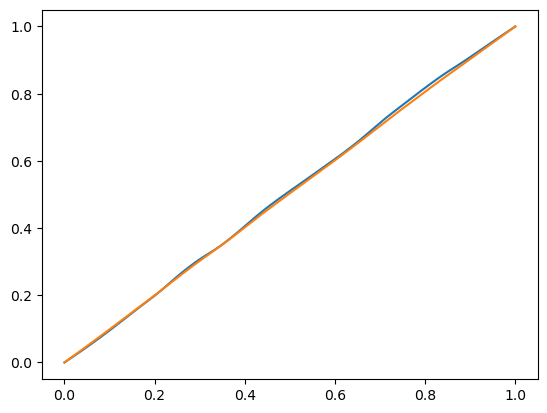

In [318]:
MBL = MultiBumpLayer([3, 5, 10], init_scale=0.1)

with torch.no_grad():
        
#     MBL.project()
    plt.plot(x, MBL(x))
    MBL.project()
    plt.plot(x, MBL(x))
#     plt.plot(x, MBL.derivative(x))